In [142]:
%matplotlib inline

import pandas
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.ticker as mticker
from scipy.optimize import minimize

**[1]** **[2]** Let's load dataset into pandas dataframe and plot data to see what we are dealing with 

In [143]:
df = pandas.read_csv('data.csv')
# Delete Index column since pandas will provide its own index
del df['Index']

# Some usefull constans
weight_column_index = 'Weight'
height_column_index = 'Height'

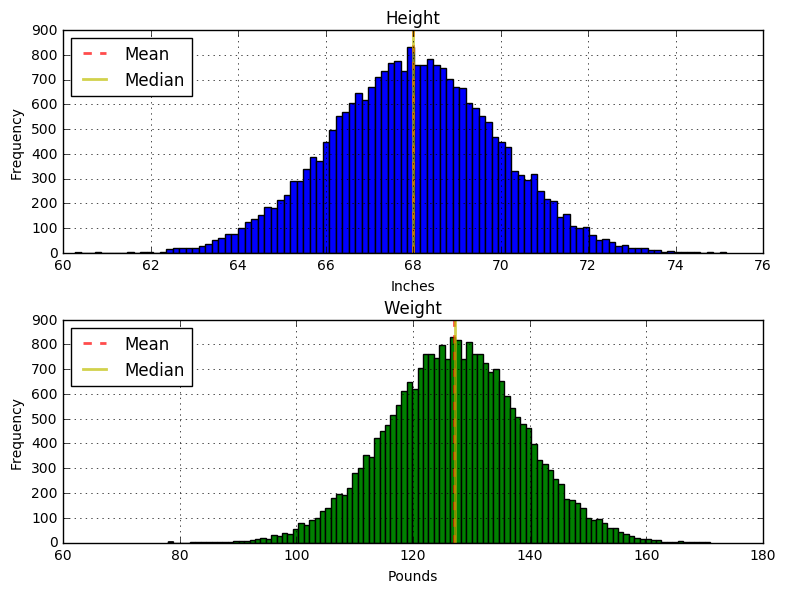

In [144]:
BINS = 100
COLORS = ['b', 'g']
Xlabels = ['Inches', 'Pounds']

# Throw error if num of colors and columns differ
assert(len(COLORS) == len(df.columns))

fig, axes = plt.subplots(len(df.columns))

# Hacky way to prevent labels overlapping
fig.tight_layout(pad=-5)
for col, axis, c, l in zip(df.columns, axes, COLORS, Xlabels):
    axis.set_ylabel("Frequency")
    axis.set_xlabel(l)
    axis.axvline(df[col].mean(), color = 'r', linestyle='dashed', linewidth=2, alpha=0.7, label="Mean")
    axis.axvline(df[col].median(), color = 'y', linewidth=2, alpha=0.7, label="Median")
    axis.legend(loc='upper left')
    df.hist(column = col, bins = BINS, ax=axis, color=c)

**[3.1]** Now let's add another feature: [BMI](https://en.wikipedia.org/wiki/Body_mass_index), and see how it is dependent on height and weight

In [151]:
# Since our data in inches and pounds we must apply conversion factor
BMI_column = np.around(np.multiply(np.divide(df[weight_column_index], np.power(df[height_column_index],2)), 703),
                       decimals=5)

# Give a name to our new column 
BMI_column_index = "BMI"
df[BMI_column_index] = BMI_column

# Make sure we actually added column to dataframe
assert(BMI_column_index in df.columns)

**[3.2]** And plot correlation matrix for all features

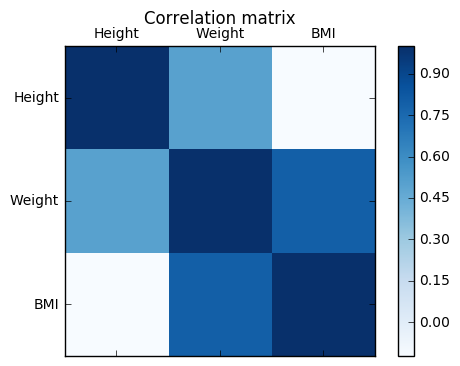

In [179]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df.corr(), interpolation='nearest', cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels(['']+df.columns.tolist())
ax.set_yticklabels(['']+df.columns.tolist())
plt.title("Correlation matrix")
plt.show()

**[4]** After we calculated `BMI` let's categorize weitgh in three categories:
+ 1 - lower than 120 pounds
+ 3 - greater or equal 150 pounds
+ 2 - everything else

In [181]:
# Categorize data according with requirements
def categorize(row):
    if row[weight_column_index] < 120: return 1
    elif row[weight_column_index] >= 150: return 3
    else: return 2

category_weight_column_index = 'Weight_Category'
# Add new column to dataframe as category type    
df[category_weight_column_index] = df.apply(categorize, axis=1).astype('category')

# Make sure we actually added column to dataframe
assert(category_weight_column_index in df.columns)

And plot it boxplot of `Height` against `Weight_Category`

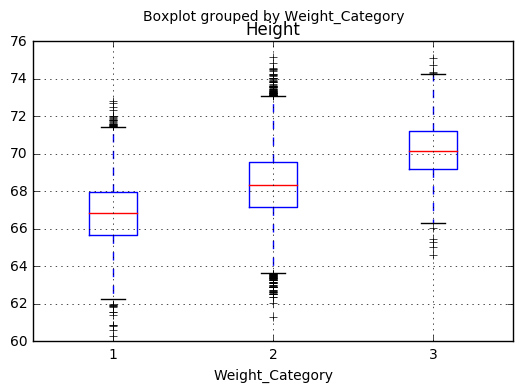

In [182]:
df.boxplot(column=height_column_index, by=category_weight_column_index)

**[5]** In addition let's plot scatterplot of height against weight.

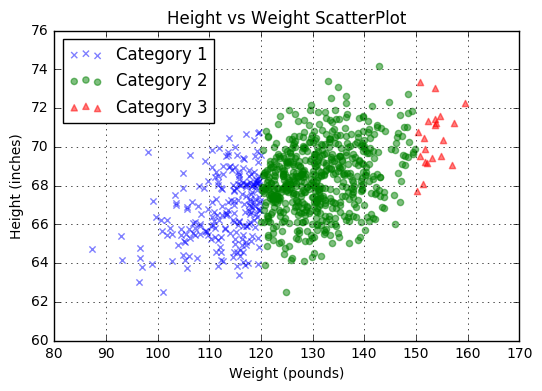

In [9]:
# Change it to sample each `sample` point
sample = 30

plt.figure()
# We will plot data by category on one plot
plt.scatter(x=df[weight_column_index][df[category_weight_column_index] == 1][::sample],
            y=df[height_column_index][df[category_weight_column_index] == 1][::sample],
            marker = 'x',
            color = 'b',
            label = 'Category 1',
            alpha = 0.5)

plt.scatter(x=df[weight_column_index][df[category_weight_column_index] == 2][::sample],
            y=df[height_column_index][df[category_weight_column_index] == 2][::sample],
            marker = 'o',
            color = 'g',
            label = 'Category 2',
            alpha = 0.5)

plt.scatter(x=df[weight_column_index][df[category_weight_column_index] == 3][::sample],
            y=df[height_column_index][df[category_weight_column_index] == 3][::sample],
            marker = '^',
            color = 'r',
            label = 'Category 3',
            alpha = 0.5)

plt.legend(loc='upper left')
plt.title('Height vs Weight ScatterPlot')
plt.ylabel('Height (inches)')
plt.xlabel('Weight (pounds)')
plt.grid()

plt.show()

Plot looks alright, but that's not enough. We have so many data points that they overlap each other resulting in big colorful blob which doesn't tell us much. Sampling less points doesn't does the trick, additionaly we mihght lose data. Perhaps heatmap will better suit our neads.

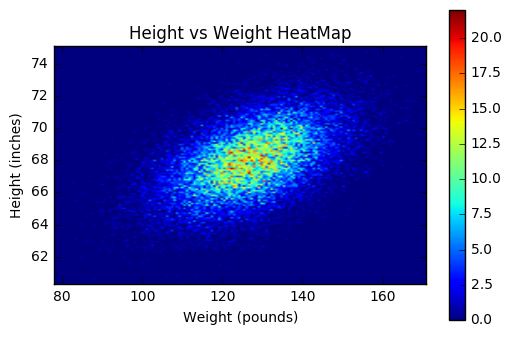

In [10]:
# Number of bins used to split data
bins = 150

heatmap, xedges, yedges = np.histogram2d(df[weight_column_index], df[height_column_index], bins=bins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect=4)
plt.colorbar()
plt.title('Height vs Weight HeatMap')
plt.ylabel('Height (inches)')
plt.xlabel('Weight (pounds)')

plt.show()

**[6]** Now let's try to fit data to polynomial. We will be trying first order polynomial. But first of all we define cost function

In [183]:
# vectorized implementation of the polynomial
def polynomial(w0, w1, x):
    return np.add(w0, np.multiply(w1, x))


# loop implementation of the polynomial
def naivepolynomial(w0, w1, x):
    y = []
    for x_ in x:
        y.append(w0+w1*x_)
    return y

# Squared error 
def error(w0, w1, y, x):
    return np.sum(np.power(np.subtract(y, polynomial(w0, w1, x)),2))

def prederror(pred, y):
    return np.sum(np.power(np.substract(y, pred)), 2)

**[7]** Then we plot two polynomials with weights `(55,0.04)` and `(50,0.22)` on scatter plot from **[5]**

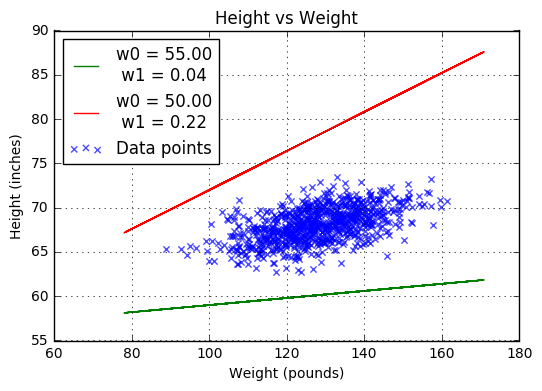

In [184]:
# Define function for easier plotting
def plotScatter(sample, x, y, weights, colors):
    plt.figure()

    plt.scatter(x=x[::sample],
                y=y[::sample],
                marker = 'x',
                color = 'b',
                alpha = 0.7,
                label = 'Data points')


    x = df[weight_column_index]


    for w, c in zip(weights, colors):
        w0, w1 = w[0], w[1]
        plt.plot(x, polynomial(w0, w1, x), label="w0 = {:.2f}\n w1 = {:.2f}".format(w0,w1), color=c)


    plt.title('Height vs Weight')
    plt.ylabel('Height (inches)')
    plt.xlabel('Weight (pounds)')
    plt.legend(loc='upper left')
    plt.grid()

    plt.show()

# Change it to sample each `skip_points`
sample = 30

# We also will plot Line of best fit to see how our weights compare to it. Do not forget to reverse order 
# of return arguments since polyfit returns highest powers first
weights = ((55,0.04), (50,0.22))
colors = ('green', 'red')

    
plotScatter(sample, df[weight_column_index], df[height_column_index], weights, colors)

**[8]** Let's see how error function depends on `w1` for `w0` = 50

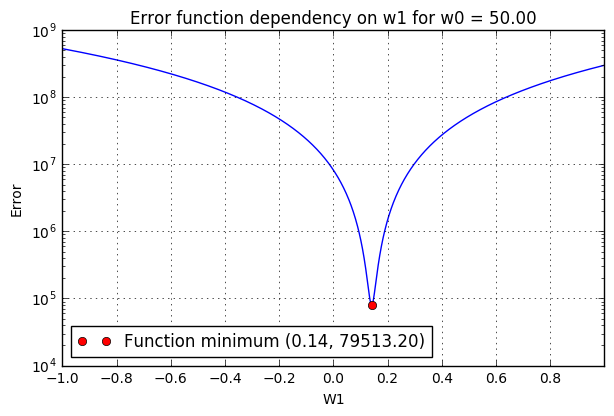

In [185]:
import sys
w0 = 50

# Changing this will change w1 range
w1_range = 1
w1 = np.linspace(-w1_range, w1_range, num=1000)

# Calculate error values
y = []

y_min = sys.maxsize
min_w1 = 0
for w in w1:
    err = error(w0,w,df[height_column_index], df[weight_column_index])
    if err < y_min:
        min_w1 = w
        y_min = err
    y.append(err)

plt.figure()
plt.plot(w1, y)
plt.plot(min_w1, y_min, 'or', label = "Function minimum ({:.2f}, {:.2f})".format(min_w1, y_min))
plt.tight_layout()

# We will put ticks at 0.2*w1_range from each other 
# thus plotting cleaner graph
plt.xticks(np.arange(min(w1), max(w1), 0.2*w1_range))

# Switch to logarithm scale if max(y) is orders of magnitude larger than min(y) 
if max(y)/min(y) > 10**3: 
    plt.semilogy()

plt.title("Error function dependency on w1 for w0 = {:.2f}".format(w0))
plt.xlabel("W1")
plt.ylabel("Error")
plt.legend(loc='lower left')
plt.grid()
plt.show()

**[9]** Now we will find minimum of error function: squared error in our case, using batch gradient descent. Plot line with resulted weights on scatter plot from **[5]** 

Squared error function minimum value is 67545.29 for w1 = 0.08


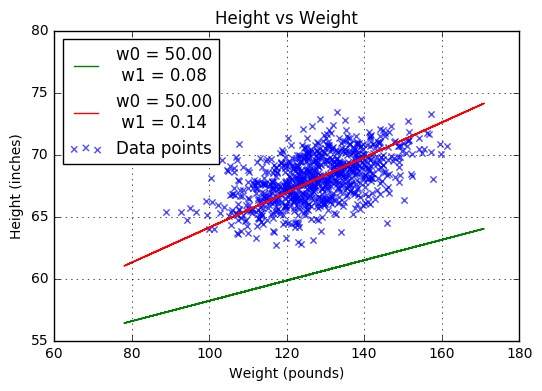

In [186]:
def gradientDescent(x, y, theta, alpha, numIterations):
    m = x.shape[0]
    old_cost = 0
    history = []
    for i in range(0, numIterations):
        predictions = np.dot(x, theta)
        loss = predictions - y

        cost = np.sum(np.power(loss,2)) 
        
        # Break execution if cost doesn't decrease substantially
        if np.abs(cost - old_cost) < 0.0001:
            break
        old_cost = cost
        history.append(cost)
        gradient = 2 * np.dot(x.T, loss) / m
        theta = theta - alpha * gradient
    return (theta, np.array(history))

numIterations= 10000

# Center data around the mean for better convergance
# Since in our case intercept has no meaning we can do it safely
x = df[weight_column_index] - df[weight_column_index].mean()
y = df[height_column_index]


X_matrix = np.ones((x.size, 2))
X_matrix[:, 1] = x
x = X_matrix



alpha = 0.005
theta = np.random.rand(2)
data = gradientDescent(x, y, theta, alpha, numIterations)
theta, history = data

print("Squared error function minimum value is {:.2f} for w1 = {:.2f}".format(min(history), theta[1]))

w0 = 50
sample = 30
weights = ((w0, theta[1]), (w0, min_w1))
colors = ('g', 'r')
plotScatter(sample, df[weight_column_index], df[height_column_index], weights, colors)

**[10]** Plot 3D graph of error funtion defined in **[6]**

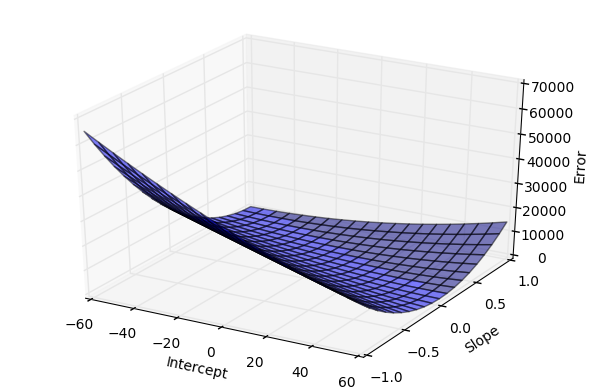

In [108]:
# Implementation curtosy of `unutbu`
# http://stackoverflow.com/questions/28542686/3d-plot-of-the-error-function-in-a-linear-regression#answer-28543587
import collections

def errorRedef(w1, w0, points):
    totalError = 0
    for i in range(0, len(points)):
        totalError += (points[i].y - (w1 * points[i].x + w0)) ** 2
    # Dividing by total amount of points simply squeezes function's range
    # without affecting its shape
    return totalError / float(len(points))

x = df[weight_column_index]
y = df[height_column_index]
Point = collections.namedtuple('Point', ['x', 'y'])

points = [Point(xp, yp) for xp,yp in zip(x, y)]

fig = plt.figure()
ax = fig.gca(projection='3d')

w1s = np.linspace(-1, 1, 20)
w0s = np.linspace(-60, 60, 20)

W1, W0 = np.meshgrid(w1s, w0s)
zs = np.array([errorRedef(w1, w0, points) 
               for w1, w0 in zip(np.ravel(W1), np.ravel(W0))])
Z = zs.reshape(W1.shape)

ax.plot_surface(B, M, Z, rstride=1, cstride=1, color='b', alpha=0.5)

ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Error')

fig.tight_layout()

plt.show()

**[11]** Finally we will minimise `error` function using BFGS algorithm and plot resulting line on top of scatter plot from **[5]**

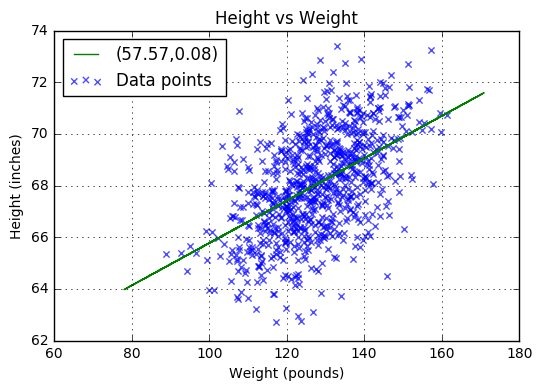

In [109]:
# Redefine error function so it can be used with scipy's minimizer
def errorOneVar(v, x, y):
    w0 = v[0]
    w1 = v[1]
    return np.sum(np.power(np.subtract(y, polynomial(w0, w1, x)),2))

result = minimize(errorOneVar, (0,0), args=(df[weight_column_index], df[height_column_index]), method='BFGS')

if result.success:
    sample = 30
    plotScatter(sample, df[weight_column_index], df[height_column_index], [result.x], 'g')
else:
    print("Couldn't minimize error function")